<a href="https://colab.research.google.com/github/Kell1000/Big_data/blob/main/TP_PySpark_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP PySpark - Introduction au Big Data avec Apache Spark
**Dataset :** `worldcitiespop.txt` — un fichier contenant des données sur les villes du monde entier (pays, nom, population, coordonnées GPS).

| Colonne    | Description                    |
| ---------- | ------------------------------ |
| Country    | Code du pays (ex : MA, FR, US) |
| City       | Nom de la ville                |
| Region     | Région administrative          |
| Population | Nombre d’habitants             |
| Latitude   | Coordonnée GPS (latitude)      |
| Longitude  | Coordonnée GPS (longitude)     |
| -----------|----------------------------------------------- |


> Ce notebook est conçu pour fonctionner directement sur **Google Colab** sans aucune configuration supplémentaire.


## Partie 0 — Installation de PySpark (à exécuter en premier !)
Google Colab n'a pas PySpark préinstallé. On l'installe avec `pip`, puis on configure Java (nécessaire pour Spark).


Apache Spark (le moteur derrière PySpark) est écrit en Java.

Donc :

PySpark = interface Python

Spark = moteur Java

Sans Java → Spark ne peut pas fonctionner

Même si tu codes en Python, Spark exécute les traitements en Java en arrière-plan.

In [ ]:
# Installation de PySpark

!pip install pyspark -q

# Vérification de la version Java (Spark en a besoin)
!java -version

openjdk version "17.0.17" 2025-10-21
OpenJDK Runtime Environment (build 17.0.17+10-Ubuntu-122.04)
OpenJDK 64-Bit Server VM (build 17.0.17+10-Ubuntu-122.04, mixed mode, sharing)


En mode local (ex: Google Colab ou ton PC) il n’y a pas plusieurs machines physiques.

*Spark simule le parallélisme en utilisant :*
Threads CPU (unités légères d’exécution dans un même processus)
```
Cluster réel
Machine 1 → Executor
Machine 2 → Executor
Machine 3 → Executor
```

```
sur Colab
Une seule machine
    ├── Thread 1 → Partition 1
    ├── Thread 2 → Partition 2
    ├── Thread 3 → Partition 3

```

par exemple si en faite: `spark = SparkSession.builder.master("local[*]").getOrCreate()`

* `local[*] `signifie :
* Utilise tous les cœurs CPU disponibles
* Chaque cœur exécute un thread


Spark parallélise les tâches de chargement et de transformation des données.
* Exemple:
* Data is stored in S3
* Spark splits data into partitions
* Driver coordinates everything
* Executors process data in parallel

---



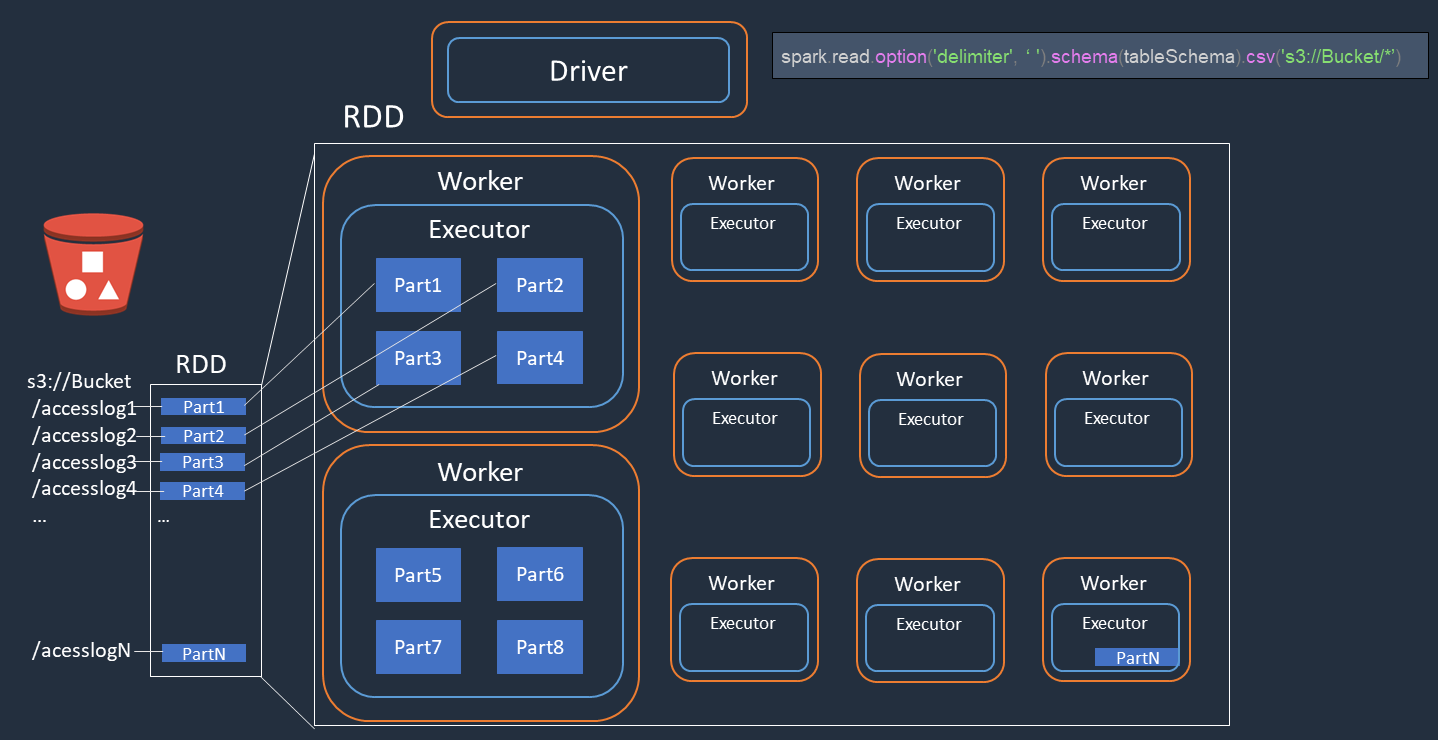

In [ ]:
print("Génération d'un fichier worldcitiespop.txt de démonstration...")
demo_data = """Country,City,AccentCity,Region,Population,Latitude,Longitude
jp,tokyo,Tokyo,40,31480498,35.685,139.751389
cn,shanghai,Shanghai,23,14608512,31.045556,121.399722
in,bombay,Bombay,16,12692717,18.975,72.825833
pk,karachi,Karachi,05,11627378,24.9056,67.0822
in,delhi,Delhi,07,10928270,28.666667,77.216667
in,new delhi,New Delhi,07,295000,28.6,77.2
ph,manila,Manila,D9,10443877,14.6042,120.9822
ru,moscow,Moscow,48,10381288,55.752222,37.615556
kr,seoul,Seoul,11,10323448,37.5985,126.9783
br,sao paulo,São Paulo,27,10021437,-23.473293,-46.665803
tr,istanbul,Istanbul,34,9797536,41.018611,28.964722
ng,lagos,Lagos,05,8789133,6.453056,3.395833
mx,mexico,Mexico,09,8720916,19.434167,-99.138611
id,jakarta,Jakarta,04,8540306,-6.174444,106.829444
us,new york,New York,NY,8107916,40.7141667,-74.0063889
cd,kinshasa,Kinshasa,06,7787832,-4.3,15.3
eg,cairo,Cairo,11,7734602,30.05,31.25
pe,lima,Lima,15,7646786,-12.05,-77.05
cn,peking,Peking,22,7480601,39.928889,116.388333
gb,london,London,H9,7421228,51.514125,-0.093689
co,bogota,Bogotá,34,7102602,4.649178,-74.062827
fr,paris,Paris,A8,2138551,48.8534,2.3488
de,berlin,Berlin,16,3426354,52.5244,13.4105
es,madrid,Madrid,29,3255944,40.4165,-3.7026
it,rome,Rome,07,2627660,41.896,12.4823
us,los angeles,Los Angeles,CA,3694820,34.0522342,-118.2427831
us,chicago,Chicago,IL,2841952,41.85,-87.6501
us,houston,Houston,TX,2027712,29.7632836,-95.3632715
ca,toronto,Toronto,08,2503281,43.7,-79.4163
au,sydney,Sydney,02,3276207,-33.8678,151.2073
cn,guangzhou,Guangzhou,30,1507266,23.1167,113.25
in,hyderabad,Hyderabad,40,3449882,17.3667,78.4667
in,chennai,Chennai,25,4352760,13.0878,80.2785
in,kolkata,Kolkata,28,5021458,22.5411,88.3378
br,rio de janeiro,Rio de Janeiro,21,5598953,-22.902778,-43.172222
ar,buenos aires,Buenos Aires,07,2982146,-34.5997,-58.3819
za,johannesburg,Johannesburg,07,756653,-26.15,28.0
ng,kano,Kano,03,2828861,12,8.5
et,addis ababa,Addis Ababa,14,2763729,9.025,38.7
ke,nairobi,Nairobi,07,2750547,-1.2833,36.8167
ma,casablanca,Casablanca,09,2940623,33.5883,-7.6114
dz,algiers,Algiers,16,1609536,36.7525,3.04197
tn,tunis,Tunis,33,693210,36.8117,10.1667
us,phoenix,Phoenix,AZ,1321045,33.4483771,-112.0740373
us,philadelphia,Philadelphia,PA,1463281,39.952335,-75.163789
mx,guadalajara,Guadalajara,14,1600940,20.6667,-103.3333
br,belo horizonte,Belo Horizonte,15,2350564,-19.915,-43.915
cn,tianjin,Tianjin,26,4304000,39.1422,117.1767
bd,dhaka,Dhaka,81,6892000,23.7231,90.4086
pk,lahore,Lahore,04,5143495,31.558,74.3507
mm,rangoon,Rangoon,03,3361700,16.7834,96.1667
th,bangkok,Bangkok,40,6320174,13.75,100.5167
vn,ho chi minh city,Ho Chi Minh City,23,3467331,10.7833,106.6667
my,kuala lumpur,Kuala Lumpur,14,1297526,3.1667,101.7
sg,singapore,Singapore,00,3547809,1.2931,103.8558
tw,taipei,Taipei,03,2626138,25.0358,121.52
cn,wuhan,Wuhan,17,4344600,30.5872,114.2881
cn,chengdu,Chengdu,32,3478231,30.6667,104.0667
cn,xian,Xian,61,2076900,34.2583,108.9286
ir,tehran,Tehran,26,7314819,35.7,51.4215
iq,baghdad,Baghdad,06,5672513,33.35,44.4167
sa,riyadh,Riyadh,14,2803334,24.6877,46.7219
il,tel aviv,Tel Aviv,TA,360400,32.0667,34.7667
gr,athens,Athens,L3,729137,37.9795,23.7162
pl,warsaw,Warsaw,79,1714446,52.23,21.0
ro,bucharest,Bucharest,10,1921578,44.4,26.1
hu,budapest,Budapest,BU,1706566,47.5,19.0833
cz,prague,Prague,52,1165581,50.0833,14.4667
at,vienna,Vienna,09,1556949,48.2,16.3667
ch,zurich,Zurich,ZH,364528,47.3786,8.54
nl,amsterdam,Amsterdam,07,1115641,52.35,4.9166
be,brussels,Brussels,01,1018500,50.85,4.35
se,stockholm,Stockholm,26,761721,59.3508,18.0973
no,oslo,Oslo,12,517401,59.9133,10.7389
dk,copenhagen,Copenhagen,17,501285,55.6786,12.5635
fi,helsinki,Helsinki,01,558457,60.1756,24.9341
pt,lisbon,Lisbon,14,517802,38.7167,-9.1333
"""
    with open('worldcitiespop.txt', 'w', encoding='utf-8') as f:
        f.write(demo_data)
    print("Fichier worldcitiespop.txt créé avec succès !")
    print(f"Nombre de lignes: {len(demo_data.strip().split(chr(10)))}")

Tentative de téléchargement du vrai fichier worldcitiespop.txt...
Génération d'un fichier worldcitiespop.txt de démonstration...
Fichier worldcitiespop.txt créé avec succès !
Nombre de lignes: 79


## Partie I — Mise en route de PySpark

###Initialiser PySpark et lire un fichier

> - `SparkContext` est le point d'entrée de Spark. Il représente la connexion à cluster (ou en local sur votre machine).
> - `SparkSession` est la version moderne et enrichie de SparkContext (utilisée depuis Spark 2.0+).

> - Un RDD (Resilient Distributed Dataset) est la structure de données fondamentale de Apache Spark.
* RDD is divided into partitions.
A partition is simply a chunk of data.


In [ ]:
#Suppose you create this RDD:
rdd = spark.sparkContext.parallelize([1,2,3,4,5,6,7,8], 4)

Partition 0 → [1, 2]
Partition 1 → [3, 4]
Partition 2 → [5, 6]
Partition 3 → [7, 8]

In [ ]:
from pyspark.sql import SparkSession

# Création d'une session Spark
spark = SparkSession.builder \
    .appName("MonApp") \
    .master("local[*]") \   # exécution locale avec tous les cœurs
    .getOrCreate()

# Accéder au SparkContext
sc = spark.sparkContext

SparkSession est l’interface principale pour travailler avec Spark depuis Spark 2.x et plus.

Il remplace l’ancien SparkContext + SQLContext + HiveContext pour les DataFrames et SQL.

* Lire et écrire des données (CSV, JSON, Parquet, etc.)

* Créer des DataFrames

* Faire des requêtes SQL directement

* Accéder au SparkContext si nécessaire (spark.sparkContext)

| Fonction / Attribut     | Description                                                                      |
| ----------------------- | -------------------------------------------------------------------------------- |
| `read`                  | Lire des fichiers en DataFrame (`csv`, `json`, `parquet`, etc.)                  |
| `readStream`            | Lire des flux de données (Streaming)                                             |
| `createDataFrame(data)` | Créer un DataFrame à partir d’une liste ou d’un RDD                              |
| `sql(query)`            | Exécuter une requête SQL sur les DataFrames enregistrés comme tables temporaires |
| `stop()`                | Arrêter la session Spark et libérer les ressources                               |
| `sparkContext`          | Accès direct au SparkContext si nécessaire                                       |


In [ ]:
#Importation de SparkContext et Initialisation du SparkContext
from pyspark import SparkContext
sc = SparkContext(appName="MonApplication")
#appName : Nom de votre application Spark.
#master (optionnel) : Définir le mode d’exécution (local[*], yarn, etc.).

| Attribut             | Description                                                 |
| -------------------- | ----------------------------------------------------------- |
| `version`            | Version de Spark utilisée.                                  |
| `appName`            | Nom de l’application Spark.                                 |
| `master`             | URL du master auquel le SparkContext est connecté.          |
| `defaultParallelism` | Niveau de parallélisme par défaut pour les RDD.             |
| `uiWebUrl`           | URL de l’interface Web Spark (pour le suivi et monitoring). |


Fonctions principales / Méthodes


*   Création et gestion des RDD
*   Contrôle et configuration



| Fonction                                   | Description                                                                                   |
| ------------------------------------------ | --------------------------------------------------------------------------------------------- |
| `parallelize(collection, numSlices=None)`  | Distribue une collection Python locale sous forme de RDD. `numSlices` = nombre de partitions. |
| `textFile(path, minPartitions=None)`       | Lit un fichier texte (local, HDFS, S3) et retourne un RDD (chaque ligne = un élément).        |
| `wholeTextFiles(path, minPartitions=None)` | Lire un dossier de fichiers textes et retourne des paires `(nom_fichier, contenu)`.            |
| `binaryFiles(path, minPartitions=None)`    | Lit des fichiers binaires (images, etc.) et retourne `(nom_fichier, contenu)`.                |



| Fonction             | Description                                                                           |
| -------------------- | ------------------------------------------------------------------------------------- |
| `stop()`             | Arrête le SparkContext et libère les ressources.                                      |
| `setLogLevel(level)` | Définit le niveau de log (`ALL`, `DEBUG`, `INFO`, `WARN`, `ERROR`, `FATAL`, `OFF`).   |
| `addFile(path)`      | Envoie un fichier à tous les nœuds travailleurs.                                      |
| `addPyFile(path)`    | Envoie un fichier Python ou zip à tous les nœuds travailleurs.                        |
| `broadcast(value)`   | Diffuse une variable en lecture seule sur tous les nœuds.                             |
| `accumulator(value)` | Crée un compteur ou accumulateur pour agréger des valeurs sur les tâches distribuées. |


In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

# Configuration de Spark pour tourner en local
# "local[*]" = utiliser tous les cœurs CPU disponibles
conf = SparkConf().setAppName("TP_PySpark").setMaster("local[*]")

# Créer le SparkContext (vérifier s'il existe déjà pour éviter les erreurs Colab)
try:
    sc = SparkContext.getOrCreate(conf=conf)
    print("hi")
except:
    sc = SparkContext.getOrCreate()
    print("hiii")

print("SparkContext créé avec succès !")
print(f"Version de Spark : {sc.version}")
print(f"Nombre de cœurs utilisés : {sc.defaultParallelism}")

hi
SparkContext créé avec succès !
Version de Spark : 4.0.2
Nombre de cœurs utilisés : 2


In [ ]:
# Lire le fichier texte et créer un RDD
# sc.textFile() lit chaque ligne du fichier comme un élément du RDD
rddStr = sc.textFile("worldcitiespop.txt")

# collect() ramène toutes les données vers le driver (à éviter sur de gros fichiers !)
lignes = rddStr.collect()

print("Les 5 premières lignes du fichier :")
for ligne in lignes[:5]:
    print(repr(ligne))

print(f"\n Nombre total de lignes : {rddStr.count()}")

Les 5 premières lignes du fichier :
'Country,City,AccentCity,Region,Population,Latitude,Longitude'
'jp,tokyo,Tokyo,40,31480498,35.685,139.751389'
'cn,shanghai,Shanghai,23,14608512,31.045556,121.399722'
'in,bombay,Bombay,16,12692717,18.975,72.825833'
'pk,karachi,Karachi,05,11627378,24.9056,67.0822'

 Nombre total de lignes : 79


## Partie II — Nettoyage des données

### Filtrer les lignes valides


> - Une ligne d'en-tête (`Country,City,...`)
> - Des lignes avec des données complètes (avec population)
> - Des lignes avec population manquante (colonne vide)
>
> On va utiliser les **transformations** Spark :
> - `filter()` : garde uniquement les éléments qui satisfont une condition
> - `map()` : transforme chaque élément (comme un "apply" en pandas)
>
> Les transformations Spark sont **lazy** (paresseuses) Cela signifie que Spark ne calcule rien tout de suite, mais construit un plan d’exécution logique appelé DAG (Directed Acyclic Graph) des transformations.: elles ne s'exécutent que quand on appelle une **action** comme `count()`, `collect()`, `take()`.

In [ ]:
# Format du fichier : Country,City,AccentCity,Region,Population,Latitude,Longitude
# Indices :            0       1    2          3       4           5        6

def parse_ligne(ligne):
    """Parse une ligne CSV et retourne un tuple structuré"""
    parts = ligne.split(',')
    return parts

def est_valide(parts):
    """Vérifie si une ligne est valide (a une population non vide)"""
    if len(parts) < 7:
        return False
    # Ignorer l'en-tête
    if parts[0] == 'Country' or parts[0] == 'country':
        return False
    # Vérifier que la population est présente et est un nombre
    try:
        pop = int(parts[4])
        return pop > 0
    except (ValueError, IndexError):
        return False

# Pipeline de nettoyage :
# 1. On lit les lignes brutes
# 2. On les parse (split par virgule)
# 3. On filtre pour ne garder que les valides
rddBrut = sc.textFile("worldcitiespop.txt")

rddParse = rddBrut.map(parse_ligne)         # Transformer chaque ligne en liste
rddValide = rddParse.filter(est_valide)     # Garder uniquement les lignes valides

# ACTION : compter les lignes valides (déclenche le calcul)
nb_total = rddBrut.count()
nb_valide = rddValide.count()

print(f"Nombre total de lignes : {nb_total}")
print(f"Lignes valides (avec population) : {nb_valide}")
print(f"Lignes ignorées : {nb_total - nb_valide}")

print("\n Exemples de lignes valides :")
for ligne in rddValide.take(3):
    print(ligne)

Nombre total de lignes : 79
Lignes valides (avec population) : 77
Lignes ignorées : 2

 Exemples de lignes valides :
['jp', 'tokyo', 'Tokyo', '40', '31480498', '35.685', '139.751389']
['cn', 'shanghai', 'Shanghai', '23', '14608512', '31.045556', '121.399722']
['in', 'bombay', 'Bombay', '16', '12692717', '18.975', '72.825833']


## Partie III — Statistiques sur les populations

### Min, Max, Somme, Moyenne

> On va extraire uniquement la colonne "Population" (index 4) pour calculer des statistiques.
>
> Spark offre des méthodes intégrées sur les RDD de nombres :
> - `.min()`, `.max()`, `.sum()`, `.mean()` pour des statistiques simples
> - `.stats()` pour un résumé complet
>
> On utilise `.map()` pour extraire la population de chaque ligne.

In [ ]:
# Extraire uniquement les populations (convertir en int)
rddPopulation = rddValide.map(lambda parts: int(parts[4]))

# Calculer les statistiques
pop_min = rddPopulation.min()
pop_max = rddPopulation.max()
pop_sum = rddPopulation.sum()
pop_count = rddPopulation.count()
pop_mean = pop_sum / pop_count

# stats() retourne un objet avec toutes les stats d'un coup (plus efficace)
stats = rddPopulation.stats()

print("=" * 50)
print("STATISTIQUES SUR LES POPULATIONS DES VILLES")
print("=" * 50)
print(f"Nombre de villes   : {pop_count:>15,}")
print(f"Population minimum : {pop_min:>15,} habitants")
print(f"Population maximum : {pop_max:>15,} habitants")
print(f"Population totale  : {pop_sum:>15,} habitants")
print(f"Population moyenne : {pop_mean:>15,.0f} habitants")
print(f"Écart-type         : {stats.stdev():>15,.0f} habitants")
print("\n Résumé Spark stats() :")
print(stats)

STATISTIQUES SUR LES POPULATIONS DES VILLES
Nombre de villes   :              77
Population minimum :         295,000 habitants
Population maximum :      31,480,498 habitants
Population totale  :     358,876,380 habitants
Population moyenne :       4,660,732 habitants
Écart-type         :       4,624,048 habitants

 Résumé Spark stats() :
(count: 77, mean: 4660732.207792208, stdev: 4624048.1339697, max: 31480498.0, min: 295000.0)


## Partie IV — Histogramme en échelle logarithmique

###Calculer les classes de fréquences

> On veut regrouper les villes par "taille" en utilisant une **échelle logarithmique** :
>
> | Classe | Intervalle de population |
> |--------|--------------------------|
> | 0      | [1 .. 10[                |
> | 1      | [10 .. 100[              |
> | 2      | [100 .. 1 000[           |
> | 3      | [1 000 .. 10 000[        |
> | 4      | [10 000 .. 100 000[      |
> | 5      | [100 000 .. 1 000 000[   |
> | 6      | [1 000 000 .. 10 000 000[|
> | 7      | [10 000 000 .. ∞[        |
>
> La **classe** d'une ville = `floor(log10(population))`
>
> On utilise un pattern **MapReduce** classique :
> - `map()` : associe chaque ville à sa classe
> - `reduceByKey()` : compte le nombre de villes par classe

`floor(...)`

Arrondit à l’entier inférieur.

*Exemple : `floor(log10(150)) = floor(2.176) = 2`

`int(...)`

*Transforme le résultat en nombre entier, pour obtenir la classe finale.

In [ ]:
from math import log10, floor

def calculer_classe(population):
    """Calcule la classe logarithmique d'une population"""
    if population <= 0:
        return 0
    return int(floor(log10(population)))

# MapReduce pour calculer l'histogramme :
# 1. map : chaque ville → (classe, 1)
# 2. reduceByKey : additionner les 1 pour chaque classe → (classe, count)
histogramme = (rddValide
    .map(lambda parts: int(parts[4]))           # extraire population
    .map(lambda pop: (calculer_classe(pop), 1)) # (classe, 1) pour chaque ville
    .reduceByKey(lambda a, b: a + b)            # sommer par classe
    .sortByKey()                                 # trier par classe croissante
    .collect()
)

print("HISTOGRAMME DES POPULATIONS (échelle log10)")
print("=" * 55)
print(f"{'Classe':<8} {'Intervalle':<25} {'Nb villes':>10} {'Graphe'}")
print("-" * 55)

labels = {
    0: "[1 .. 10[",
    1: "[10 .. 100[",
    2: "[100 .. 1 000[",
    3: "[1 000 .. 10 000[",
    4: "[10 000 .. 100 000[",
    5: "[100 000 .. 1 M[",
    6: "[1 M .. 10 M[",
    7: "[10 M .. ∞["
}

for classe, count in histogramme:
    barre = "█" * min(count // 100, 40)  # barre proportionnelle
    label = labels.get(classe, f"Classe {classe}")
    print(f"{classe:<8} {label:<25} {count:>10,}  {barre}")

print("\nFormat compact (comme attendu dans l'énoncé) :")
print(histogramme)

HISTOGRAMME DES POPULATIONS (échelle log10)
Classe   Intervalle                 Nb villes Graphe
-------------------------------------------------------
5        [100 000 .. 1 M[                  11  
6        [1 M .. 10 M[                     57  
7        [10 M .. ∞[                        9  

Format compact (comme attendu dans l'énoncé) :
[(5, 11), (6, 57), (7, 9)]


## Partie V — Top 10 des villes les plus peuplées

### Trouver les villes avec la plus grande population

> Pour trouver les K plus grands éléments, on peut utiliser :
> - `.sortBy()` puis `.take(K)` — simple mais moins efficace
> - `.top(K)` — plus efficace car Spark optimise l'opération
>
> On trie par population (index 4) en ordre **décroissant**.

In [ ]:
# Méthode 1 : sortBy + take
# sortBy(key, ascending=False) trie par la clé en ordre décroissant
top10 = (rddValide
    .sortBy(lambda parts: int(parts[4]), ascending=False)  # trier par population desc
    .take(10)  # prendre les 10 premiers
)

print("TOP 10 DES VILLES LES PLUS PEUPLÉES")
print("=" * 70)
print(f"{'#':<4} {'Pays':<5} {'Ville':<20} {'Population':>15} {'Latitude':>10} {'Longitude':>10}")
print("-" * 70)

for i, ville in enumerate(top10, 1):
    pays = ville[0].upper()
    nom = ville[2]  # AccentCity (nom avec accents)
    pop = int(ville[4])
    lat = ville[5]
    lon = ville[6]
    print(f"{i:<4} {pays:<5} {nom:<20} {pop:>15,} {lat:>10} {lon:>10}")

print("\n Format brut :")
for ville in top10:
    print(','.join(ville))

TOP 10 DES VILLES LES PLUS PEUPLÉES
#    Pays  Ville                     Population   Latitude  Longitude
----------------------------------------------------------------------
1    JP    Tokyo                     31,480,498     35.685 139.751389
2    CN    Shanghai                  14,608,512  31.045556 121.399722
3    IN    Bombay                    12,692,717     18.975  72.825833
4    PK    Karachi                   11,627,378    24.9056    67.0822
5    IN    Delhi                     10,928,270  28.666667  77.216667
6    PH    Manila                    10,443,877    14.6042   120.9822
7    RU    Moscow                    10,381,288  55.752222  37.615556
8    KR    Seoul                     10,323,448    37.5985   126.9783
9    BR    São Paulo                 10,021,437 -23.473293 -46.665803
10   TR    Istanbul                   9,797,536  41.018611  28.964722

 Format brut :
jp,tokyo,Tokyo,40,31480498,35.685,139.751389
cn,shanghai,Shanghai,23,14608512,31.045556,121.399722
in,bomba

## Partie VI — Suppression des doublons géographiques

### Dédoublonnage par position géographique

> On remarque que "Delhi" et "New Delhi" sont deux entrées pour la même ville (même zone géographique).
> On veut **garder uniquement la ville avec la plus grande population** parmi celles qui sont au même endroit.
>
> **Stratégie :**
> 1. Créer une **clé géographique** : arrondir les coordonnées GPS à 1 décimale
>    → Des villes très proches auront la même clé (ex: `(28.7, 77.2)`)
> 2. Grouper par cette clé avec `reduceByKey()` : garder la ville avec `max(population)`
>
> **Pattern MapReduce :**
> - `map` : `ligne → ((lat_arrondi, lon_arrondi), ligne)`
> - `reduceByKey` : pour chaque clé géo, garder la ligne avec la plus grande population
> - `map` : extraire juste les lignes (sans les clés)

In [ ]:
def cle_geographique(parts):
    """
    Crée une clé géographique en arrondissant les coordonnées à 1 décimale.
    Deux villes très proches (ex: Delhi et New Delhi) auront la même clé.
    """
    try:
        lat = round(float(parts[5]), 1)
        lon = round(float(parts[6]), 1)
        return (lat, lon)
    except (ValueError, IndexError):
        return (0.0, 0.0)

def garder_plus_grande_population(ville1, ville2):
    """Compare deux villes et retourne celle avec la plus grande population"""
    pop1 = int(ville1[4])
    pop2 = int(ville2[4])
    return ville1 if pop1 >= pop2 else ville2

# Pipeline de dédoublonnage :
# 1. (cle_geo, ligne) pour chaque ville
# 2. reduceByKey : pour chaque clé, garder la ville la plus peuplée
# 3. .values() : on enlève les clés, on garde juste les villes
rddDedoublonne = (rddValide
    .map(lambda parts: (cle_geographique(parts), parts))  # (clé_geo, données)
    .reduceByKey(garder_plus_grande_population)            # garder la plus peuplée
    .values()                                               # extraire juste les données
)

nb_avant = rddValide.count()
nb_apres = rddDedoublonne.count()

print(f"Avant dédoublonnage : {nb_avant:,} villes")
print(f"Après dédoublonnage : {nb_apres:,} villes")
print(f"Doublons supprimés : {nb_avant - nb_apres:,} villes")

Avant dédoublonnage : 77 villes
Après dédoublonnage : 77 villes
Doublons supprimés : 0 villes


In [ ]:
# Recalculer les statistiques après dédoublonnage
rddPopDedoublonne = rddDedoublonne.map(lambda parts: float(parts[4]))
stats2 = rddPopDedoublonne.stats()

print("STATISTIQUES APRÈS DÉDOUBLONNAGE")
print("=" * 50)
print(stats2)

# Recalculer l'histogramme
histogramme2 = (rddDedoublonne
    .map(lambda parts: int(parts[4]))
    .map(lambda pop: (calculer_classe(pop), 1))
    .reduceByKey(lambda a, b: a + b)
    .sortByKey()
    .collect()
)

print("\n Histogramme après dédoublonnage :")
print(histogramme2)

STATISTIQUES APRÈS DÉDOUBLONNAGE
(count: 77, mean: 4660732.207792208, stdev: 4624048.133969699, max: 31480498.0, min: 295000.0)

 Histogramme après dédoublonnage :
[(5, 11), (6, 57), (7, 9)]


In [ ]:
# Top 20 après dédoublonnage (résultat attendu dans l'énoncé)
top20_dedup = (rddDedoublonne
    .sortBy(lambda parts: int(parts[4]), ascending=False)
    .take(20)
)

print("TOP 20 DES VILLES APRÈS DÉDOUBLONNAGE")
print("=" * 70)
print(f"{'#':<4} {'Pays':<5} {'Ville':<20} {'Population':>15}")
print("-" * 70)

for i, ville in enumerate(top20_dedup, 1):
    pays = ville[0].upper()
    nom = ville[2]
    pop = int(ville[4])
    print(f"{i:<4} {pays:<5} {nom:<20} {pop:>15,}")

print("\n Format brut (comme l'énoncé) :")
for ville in top20_dedup:
    print(','.join(ville))

TOP 20 DES VILLES APRÈS DÉDOUBLONNAGE
#    Pays  Ville                     Population
----------------------------------------------------------------------
1    JP    Tokyo                     31,480,498
2    CN    Shanghai                  14,608,512
3    IN    Bombay                    12,692,717
4    PK    Karachi                   11,627,378
5    IN    Delhi                     10,928,270
6    PH    Manila                    10,443,877
7    RU    Moscow                    10,381,288
8    KR    Seoul                     10,323,448
9    BR    São Paulo                 10,021,437
10   TR    Istanbul                   9,797,536
11   NG    Lagos                      8,789,133
12   MX    Mexico                     8,720,916
13   ID    Jakarta                    8,540,306
14   US    New York                   8,107,916
15   CD    Kinshasa                   7,787,832
16   EG    Cairo                      7,734,602
17   PE    Lima                       7,646,786
18   CN    Peking          

## — Visualisation avec Matplotlib

> **Explication :** On peut visualiser nos résultats directement dans Colab !

In [ ]:
import matplotlib.pyplot as plt

# --- Création de la figure ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Analyse des villes mondiales", fontsize=14, fontweight='bold')

# --- Graphe 1 : Histogramme des classes logarithmiques ---
classes = [x[0] for x in histogramme2]  # indices des classes
counts = [x[1] for x in histogramme2]   # nombre de villes par classe
labels_court = ['1-10', '10-100', '100-1K', '1K-10K', '10K-100K', '100K-1M', '1M-10M', '10M+']

axes[0].bar(classes, counts, color='skyblue')
axes[0].set_title('Distribution des populations', fontweight='bold')
axes[0].set_xlabel('Classe (puissance de 10)')
axes[0].set_ylabel('Nombre de villes')
axes[0].set_xticks(classes)
axes[0].set_xticklabels([labels_court[c] for c in classes], rotation=30, fontsize=8)
axes[0].set_yscale('log')  # échelle logarithmique pour mieux visualiser

# --- Graphe 2 : Top 10 villes les plus peuplées ---
top10_noms = [v[2] for v in top20_dedup[:10]]        # noms des villes
top10_pops = [int(v[4])/1_000_000 for v in top20_dedup[:10]]  # populations en millions

axes[1].barh(top10_noms[::-1], top10_pops[::-1], color='salmon')  # inversé pour ordre décroissant
axes[1].set_title('Top 10 villes les plus peuplées', fontweight='bold')
axes[1].set_xlabel('Population (millions)')

# --- Affichage final ---
plt.tight_layout()
plt.show()

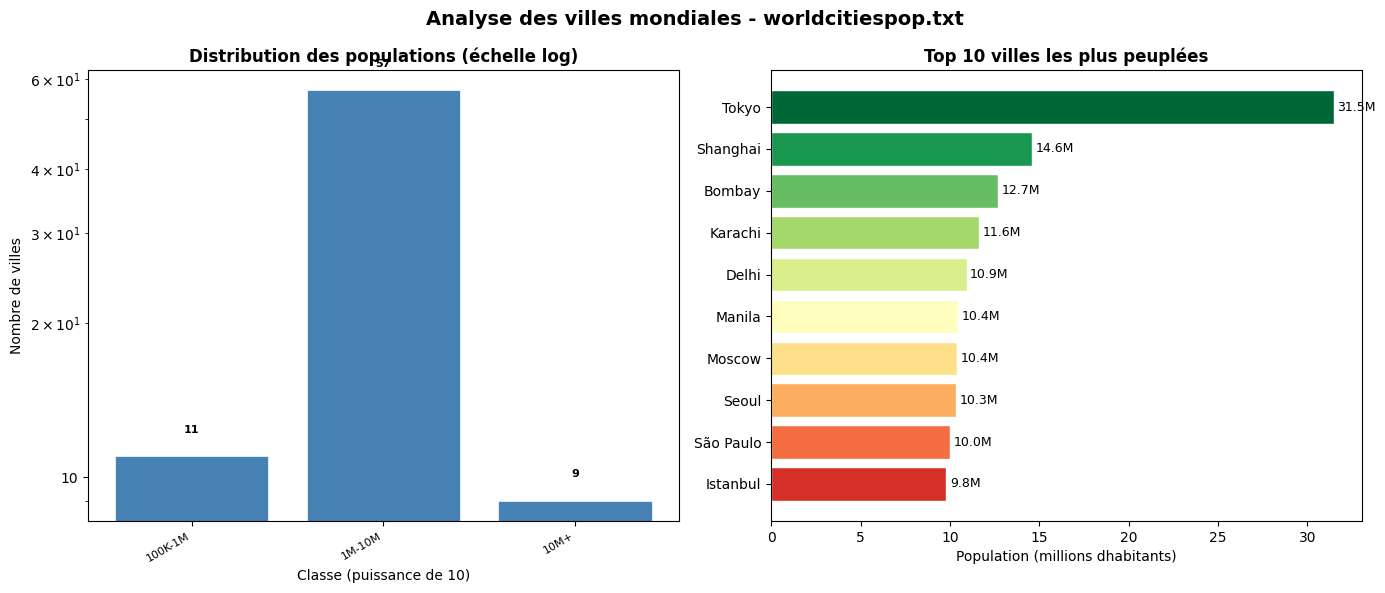

Graphique sauvegardé : analyse_villes.png


In [ ]:
# autre exemple
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Analyse des villes mondiales - worldcitiespop.txt", fontsize=14, fontweight='bold')

# --- Graphe 1 : Histogramme ---
classes = [x[0] for x in histogramme2]
counts = [x[1] for x in histogramme2]
labels_court = ['1-10', '10-100', '100-1K', '1K-10K', '10K-100K', '100K-1M', '1M-10M', '10M+']

bars = axes[0].bar(classes, counts, color='steelblue', edgecolor='white', linewidth=0.5)
axes[0].set_title('Distribution des populations (échelle log)', fontweight='bold')
axes[0].set_xlabel('Classe (puissance de 10)')
axes[0].set_ylabel('Nombre de villes')
axes[0].set_xticks(classes)
axes[0].set_xticklabels([labels_court[c] for c in classes], rotation=30, ha='right', fontsize=8)
axes[0].set_yscale('log')
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'))
for bar, count in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() * 1.1,
                f'{count:,}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# --- Graphe 2 : Top 10 populations ---
top10_noms = [v[2] for v in top20_dedup[:10]]
top10_pops = [int(v[4]) / 1_000_000 for v in top20_dedup[:10]]

colors = plt.cm.RdYlGn_r([i/10 for i in range(10)])
bars2 = axes[1].barh(range(9, -1, -1), top10_pops, color=colors, edgecolor='white')
axes[1].set_yticks(range(9, -1, -1))
axes[1].set_yticklabels(top10_noms[:10])
axes[1].set_title('Top 10 villes les plus peuplées', fontweight='bold')
axes[1].set_xlabel('Population (millions dhabitants)')
for bar, pop in zip(bars2, top10_pops):
    axes[1].text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
                f'{pop:.1f}M', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('analyse_villes.png', dpi=150, bbox_inches='tight')
plt.show()
print("Graphique sauvegardé : analyse_villes.png")

---
# Partie VII — Machine Learning avec MLlib

**MLlib** est la bibliothèque de Machine Learning intégrée à Apache Spark. Elle permet d'entraîner des modèles directement sur des données distribuées, sans avoir à les rapatrier sur une seule machine.

### Plan de cette partie :
1. — Préparation des données pour MLlib (vecteurs de features)
2. — Clustering avec K-Means (regrouper les villes par taille)
3.  — Régression linéaire (prédire la population)
4.  — Classification (prédire si une ville est "grande" ou "petite")
5. — Pipeline MLlib complet
6.  — Recommandation (ALS - Collaborative Filtering)

> MLlib utilise l'API **DataFrame** (via SparkSession) qui est plus moderne et plus performante que l'API RDD.

| Catégorie                  | Description                      | Exemples                                                                 |
| -------------------------- | -------------------------------- | ------------------------------------------------------------------------ |
| **Classification**         | Prédire des catégories           | `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier` |
| **Régression**             | Prédire des valeurs numériques   | `LinearRegression`, `DecisionTreeRegressor`                              |
| **Clustering**             | Regrouper des données similaires | `KMeans`, `GaussianMixture`                                              |
| **Filtrage collaboratif**  | Recommandation (ex : Netflix)    | `ALS` (Alternating Least Squares)                                        |
| **Réduction de dimension** | Réduire le nombre de features    | `PCA` (Principal Component Analysis), `SVD`                              |
| **Prétraitement**          | Préparer les données             | `StringIndexer`, `OneHotEncoder`, `VectorAssembler`, `StandardScaler`    |
| **Évaluation**             | Mesurer la qualité du modèle     | `BinaryClassificationEvaluator`, `RegressionEvaluator`                   |


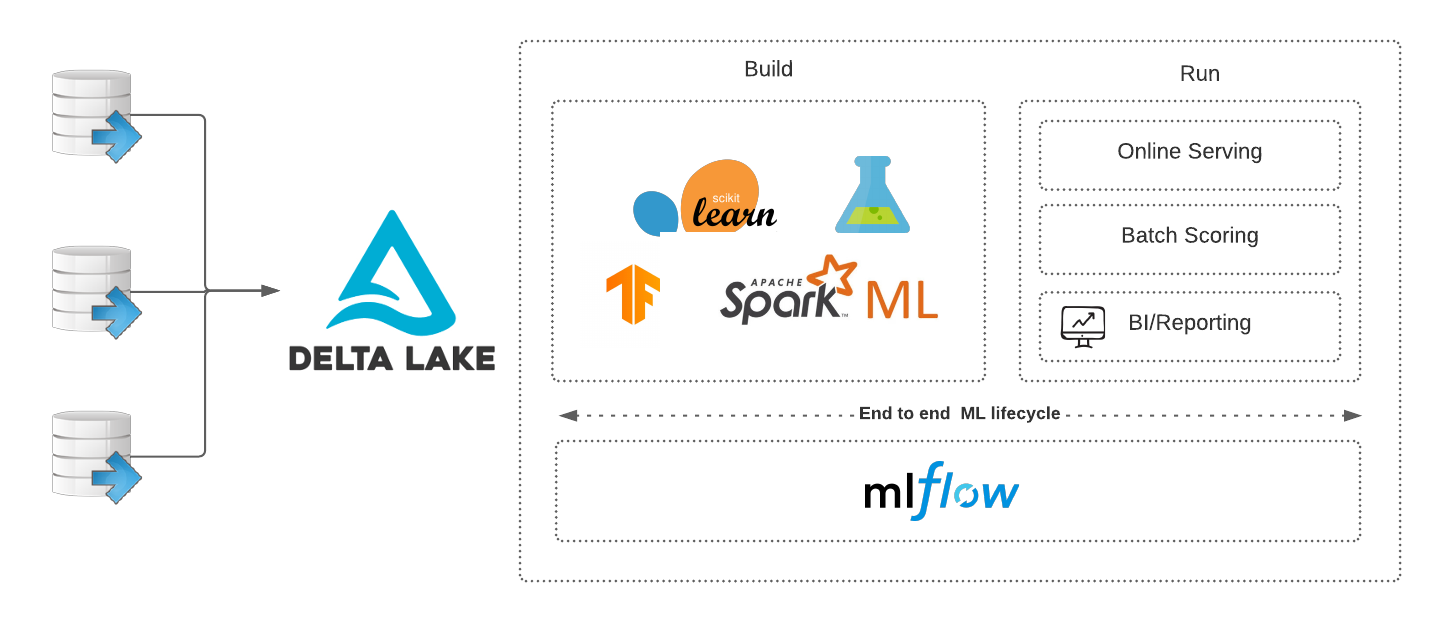

## Initialisation de SparkSession


> Pour MLlib, on utilise `SparkSession` (l'API moderne de Spark) plutôt que `SparkContext` directement.
> `SparkSession` donne accès aux DataFrames Spark, qui sont l'équivalent de tables SQL distribuées.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

# Créer une SparkSession (ou récupérer celle existante)
spark = SparkSession.builder \
    .appName("TP_PySpark_MLlib") \
    .master("local[*]") \
    .getOrCreate()

# Supprimer les logs inutiles
spark.sparkContext.setLogLevel("ERROR")

print(" SparkSession créée !")
print(f"Version Spark : {spark.version}")

 SparkSession créée !
Version Spark : 4.0.2


## Chargement des données en DataFrame

> On relit le fichier worldcitiespop.txt en **DataFrame Spark**.
> Un DataFrame Spark a un **schéma** (types de colonnes définis) et peut être manipulé avec une syntaxe proche de SQL ou pandas.
>
> Avantages par rapport au RDD :
> - Optimisation automatique des requêtes (Catalyst optimizer)
> - Syntaxe plus lisible
> - Compatible avec MLlib Pipeline API

In [ ]:
# Définir le schéma du fichier CSV
schema = StructType([
    StructField("country",    StringType(),  True),
    StructField("city",       StringType(),  True),
    StructField("accent_city",StringType(),  True),
    StructField("region",     StringType(),  True),
    StructField("population", IntegerType(), True),
    StructField("latitude",   FloatType(),   True),
    StructField("longitude",  FloatType(),   True),
])

# Lire le CSV avec le schéma
df_brut = spark.read.csv(
    "worldcitiespop.txt",
    header=True,       # La 1ère ligne est l'en-tête
    schema=schema,
    encoding="iso-8859-1"  # Gère les caractères spéciaux (São Paulo, etc.)
)

# Nettoyer : garder uniquement les villes avec population
df = df_brut.filter(F.col("population").isNotNull() & (F.col("population") > 0))

# Dédoublonnage géographique (comme Exercice 6)
# Arrondir les coordonnées GPS pour créer une clé géographique
from pyspark.sql.window import Window

df = df.withColumn("lat_r", F.round(F.col("latitude"), 1)) \
       .withColumn("lon_r", F.round(F.col("longitude"), 1))

# Garder la ville avec la plus grande population par zone géographique
window_geo = Window.partitionBy("lat_r", "lon_r").orderBy(F.col("population").desc())
df = df.withColumn("rang", F.row_number().over(window_geo)) \
       .filter(F.col("rang") == 1) \
       .drop("rang", "lat_r", "lon_r")

# Afficher un aperçu
print(f"{df.count()} villes chargées après nettoyage")
df.show(5, truncate=False)
df.printSchema()

77 villes chargées après nettoyage
+-------+--------------+--------------+------+----------+----------+----------+
|country|city          |accent_city   |region|population|latitude  |longitude |
+-------+--------------+--------------+------+----------+----------+----------+
|ar     |buenos aires  |Buenos Aires  |07    |2982146   |-34.5997  |-58.3819  |
|au     |sydney        |Sydney        |02    |3276207   |-33.8678  |151.2073  |
|za     |johannesburg  |Johannesburg  |07    |756653    |-26.15    |28.0      |
|br     |sao paulo     |SÃ£o Paulo    |27    |10021437  |-23.473293|-46.665802|
|br     |rio de janeiro|Rio de Janeiro|21    |5598953   |-22.902779|-43.172222|
+-------+--------------+--------------+------+----------+----------+----------+
only showing top 5 rows
root
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- accent_city: string (nullable = true)
 |-- region: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- latitude: fl

## — Préparation des features (VectorAssembler)


> MLlib attend des données sous forme de **vecteurs de features** (colonnes numériques regroupées en une seule colonne de type `Vector`).
>
> On utilise `VectorAssembler` pour transformer plusieurs colonnes numériques en une seule colonne `features`.
>
> On ajoute aussi :
> - `log_population` : log10 de la population (pour normaliser)
> - `classe_pop` : la classe logarithmique (utile pour la classification)
>
> **Pourquoi le logarithme ?** Les populations varient de 7 à 31 millions → une échelle log rend les données plus "linéaires" et les algorithmes convergent mieux.

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.linalg import Vectors
import math

# Ajouter des features dérivées
df_features = df.withColumn("log_pop", F.log10(F.col("population"))) \
                .withColumn("classe_pop", F.floor(F.log10(F.col("population"))).cast("int")) \
                .withColumn("pop_float", F.col("population").cast("float"))

# VectorAssembler : combine plusieurs colonnes en un seul vecteur "features"
# Ici on utilisera latitude, longitude et log_population
assembler_geo = VectorAssembler(
    inputCols=["latitude", "longitude"],
    outputCol="features_geo"
)

assembler_full = VectorAssembler(
    inputCols=["latitude", "longitude", "log_pop"],
    outputCol="features"
)

df_vec = assembler_geo.transform(df_features)
df_vec = assembler_full.transform(df_vec)

print("Features créées !")
print("\nSchéma du DataFrame avec features :")
df_vec.select("accent_city", "population", "log_pop", "classe_pop", "features").show(5, truncate=False)

Features créées !

Schéma du DataFrame avec features :
+--------------+----------+-----------------+----------+-----------------------------------------------------------+
|accent_city   |population|log_pop          |classe_pop|features                                                   |
+--------------+----------+-----------------+----------+-----------------------------------------------------------+
|Buenos Aires  |2982146   |6.474528901840715|6         |[-34.599700927734375,-58.381900787353516,6.474528901840715]|
|Sydney        |3276207   |6.515371333905737|6         |[-33.867801666259766,151.20730590820312,6.515371333905737] |
|Johannesburg  |756653    |5.878896758317265|5         |[-26.149999618530273,28.0,5.878896758317265]               |
|SÃ£o Paulo    |10021437  |7.000930000615463|7         |[-23.47329330444336,-46.665802001953125,7.000930000615463] |
|Rio de Janeiro|5598953   |6.748106821857133|6         |[-22.90277862548828,-43.17222213745117,6.748106821857133]  |
+--------

## — Clustering K-Means


> **K-Means** est un algorithme de clustering (apprentissage **non supervisé**).
> Il regroupe les données en **K clusters** de façon à ce que les points d'un même cluster soient le plus proches possible.
>
> Ici on va regrouper les villes **par leur position géographique** (latitude + longitude).
> → On s'attend à trouver des regroupements correspondant aux continents ou grandes régions du monde.
>
> **Fonctionnement de K-Means :**
> 1. Choisir K centroïdes aléatoirement
> 2. Assigner chaque point au centroïde le plus proche
> 3. Recalculer les centroïdes (barycentre de chaque cluster)
> 4. Répéter jusqu'à convergence
>
> **Métriques :**
**WSSSE (Within-Set Sum of Squared Errors) **: quantifie la dispersion interne des clusters. Plus la valeur est faible, plus les clusters sont compacts et homogènes.

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Entraîner K-Means avec K=6 clusters (≈ continents)
kmeans = KMeans(
    featuresCol="features_geo",   # utiliser lat/lon seulement
    predictionCol="cluster",
    k=6,                          # 6 clusters
    seed=42,                      # reproductibilité
    maxIter=20
)

model_kmeans = kmeans.fit(df_vec)

# Appliquer le modèle : ajouter la colonne "cluster" à chaque ville
df_clusters = model_kmeans.transform(df_vec)

# Évaluation
evaluator = ClusteringEvaluator(featuresCol="features_geo", predictionCol="cluster")
silhouette = evaluator.evaluate(df_clusters)

print(f"Score Silhouette : {silhouette:.4f}  (proche de 1 = clusters bien séparés)")
print(f"WSSSE : {model_kmeans.summary.trainingCost:.2f}")

# Afficher les centroïdes (positions moyennes de chaque cluster)
print("\n Centroïdes des clusters (latitude, longitude) :")
for i, center in enumerate(model_kmeans.clusterCenters()):
    print(f"  Cluster {i} : lat={center[0]:.2f}, lon={center[1]:.2f}")

Score Silhouette : 0.6752  (proche de 1 = clusters bien séparés)
WSSSE : 29236.18

 Centroïdes des clusters (latitude, longitude) :
  Cluster 0 : lat=48.24, lon=8.80
  Cluster 1 : lat=20.46, lon=104.26
  Cluster 2 : lat=33.73, lon=-93.82
  Cluster 3 : lat=-18.05, lon=-57.21
  Cluster 4 : lat=-0.71, lon=21.79
  Cluster 5 : lat=35.99, lon=39.21


In [ ]:
# Analyser le contenu de chaque cluster
print("Contenu des clusters (top 3 villes par cluster) :\n")

for cluster_id in range(6):
    villes_cluster = (df_clusters
        .filter(F.col("cluster") == cluster_id)
        .orderBy(F.col("population").desc())
        .select("accent_city", "country", "population", "latitude", "longitude")
        .limit(5)
        .collect()
    )
    nb = df_clusters.filter(F.col("cluster") == cluster_id).count()
    print(f"++ Cluster {cluster_id} ({nb} villes) — Top villes :")
    for v in villes_cluster[:3]:
        print(f"   {v['accent_city']:20s} ({v['country'].upper()}) — {int(v['population']):>12,} hab")
    print()

Contenu des clusters (top 3 villes par cluster) :

🔵 Cluster 0 (20 villes) — Top villes :
   London               (GB) —    7,421,228 hab
   Berlin               (DE) —    3,426,354 hab
   Madrid               (ES) —    3,255,944 hab

🔵 Cluster 1 (26 villes) — Top villes :
   Tokyo                (JP) —   31,480,498 hab
   Shanghai             (CN) —   14,608,512 hab
   Bombay               (IN) —   12,692,717 hab

🔵 Cluster 2 (9 villes) — Top villes :
   Mexico               (MX) —    8,720,916 hab
   New York             (US) —    8,107,916 hab
   Los Angeles          (US) —    3,694,820 hab

🔵 Cluster 3 (6 villes) — Top villes :
   SÃ£o Paulo           (BR) —   10,021,437 hab
   Lima                 (PE) —    7,646,786 hab
   BogotÃ¡              (CO) —    7,102,602 hab

🔵 Cluster 4 (6 villes) — Top villes :
   Lagos                (NG) —    8,789,133 hab
   Kinshasa             (CD) —    7,787,832 hab
   Kano                 (NG) —    2,828,861 hab

🔵 Cluster 5 (10 villes) — Top vi

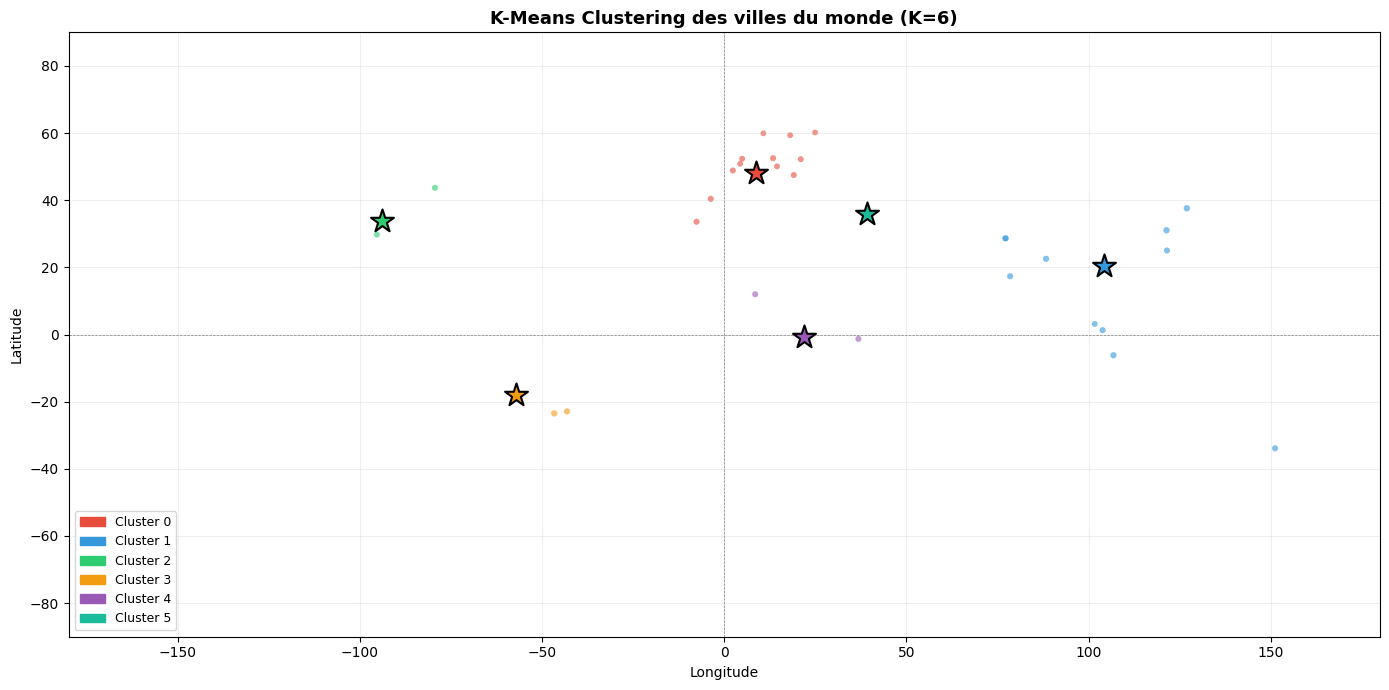

Carte sauvegardée : kmeans_villes.png


In [ ]:
# Visualiser les clusters sur une carte monde
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Collecter un échantillon de données pour la visualisation
sample = df_clusters.select("latitude", "longitude", "cluster", "population").sample(0.3, seed=42).collect()

lats = [r["latitude"] for r in sample]
lons = [r["longitude"] for r in sample]
clusters_ids = [r["cluster"] for r in sample]
pops = [max(r["population"], 1) for r in sample]

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
cluster_colors = [colors[c] for c in clusters_ids]

# Taille proportionnelle à la population (log pour ne pas écraser)
sizes = [max(np.log10(p) * 3, 5) for p in pops]

fig, ax = plt.subplots(figsize=(14, 7))
scatter = ax.scatter(lons, lats, c=cluster_colors, s=sizes, alpha=0.6, linewidths=0)

# Centroïdes
for i, center in enumerate(model_kmeans.clusterCenters()):
    ax.scatter(center[1], center[0], c=colors[i], s=300, marker='*',
               edgecolors='black', linewidths=1.5, zorder=5)

# Légende
patches = [mpatches.Patch(color=colors[i], label=f'Cluster {i}') for i in range(6)]
ax.legend(handles=patches, loc='lower left', fontsize=9)

ax.set_title("K-Means Clustering des villes du monde (K=6)", fontsize=13, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig("kmeans_villes.png", dpi=150, bbox_inches='tight')
plt.show()
print("Carte sauvegardée : kmeans_villes.png")

## — Régression Linéaire


> La **régression linéaire** est un algorithme d'apprentissage **supervisé** qui prédit une valeur numérique (variable continue).
>
> **Problème posé :** Peut-on prédire `log10(population)` d'une ville à partir de sa **position géographique** (latitude, longitude) et de son **cluster** ?
>
> Note pédagogique : en réalité la latitude/longitude ne prédit pas bien la population (une ville peut être très peuplée n'importe où). Mais c'est un bon exercice pour apprendre la syntaxe MLlib !
>
> **Étapes classiques du ML supervisé avec MLlib :**
> 1. Préparer les features et le label
> 2. Séparer les données en `train` / `test`
> 3. Entraîner le modèle sur `train`
> 4. Évaluer sur `test` (RMSE, R²)

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Préparer les features pour la régression
# Features : latitude, longitude, cluster (issu du K-Means)
assembler_reg = VectorAssembler(
    inputCols=["latitude", "longitude", "cluster"],
    outputCol="features_reg"
)
df_reg = assembler_reg.transform(df_clusters)

# Label : log10(population) — on prédit le log car la distribution est + normale
df_reg = df_reg.withColumnRenamed("log_pop", "label")

# Séparation train/test (80% entraînement, 20% test)
df_train, df_test = df_reg.randomSplit([0.8, 0.2], seed=42)

print(f"Données d'entraînement : {df_train.count()} villes")
print(f"Données de test        : {df_test.count()} villes")

# Entraîner la régression linéaire
lr = LinearRegression(
    featuresCol="features_reg",
    labelCol="label",
    maxIter=100,
    regParam=0.01,    # régularisation L2 (Ridge)
    elasticNetParam=0  # 0 = Ridge, 1 = Lasso
)

model_lr = lr.fit(df_train)

# Résultats sur les données d'entraînement
print(f"\n Coefficients : {model_lr.coefficients}")
print(f" Intercept    : {model_lr.intercept:.4f}")
print(f"\n RMSE (train) : {model_lr.summary.rootMeanSquaredError:.4f}")
print(f"R²   (train) : {model_lr.summary.r2:.4f}")

Données d'entraînement : 61 villes
Données de test        : 16 villes

 Coefficients : [-0.004007263103067223,0.0016194541875012474,0.0655148292767645]
 Intercept    : 6.4185

 RMSE (train) : 0.4103
R²   (train) : 0.1794


In [ ]:
# Évaluation sur les données de test
predictions_lr = model_lr.transform(df_test)

evaluator_reg = RegressionEvaluator(labelCol="label", predictionCol="prediction")

rmse = evaluator_reg.evaluate(predictions_lr, {evaluator_reg.metricName: "rmse"})
r2   = evaluator_reg.evaluate(predictions_lr, {evaluator_reg.metricName: "r2"})
mae  = evaluator_reg.evaluate(predictions_lr, {evaluator_reg.metricName: "mae"})

print("=" * 45)
print("ÉVALUATION SUR LES DONNÉES DE TEST")
print("=" * 45)
print(f"RMSE (Root Mean Squared Error) : {rmse:.4f}")
print(f"MAE  (Mean Absolute Error)     : {mae:.4f}")
print(f"R²   (Coefficient de déterm.)  : {r2:.4f}")
print()
print("Interprétation du R² :")
if r2 > 0.7:
    print("   → Bon modèle : le modèle explique bien la variance")
elif r2 > 0.4:
    print("   → Modèle moyen : la position géographique explique partiellement la population")
else:
    print("   → Modèle faible : la géographie seule ne prédit pas bien la population")
    print("   → C'est attendu ! Une grande ville peut exister partout dans le monde.")

# Afficher quelques prédictions
print("\n Exemples de prédictions (log10 pop) :")
print(f"{'Ville':<20} {'Réel (log)':<12} {'Prédit (log)':<14} {'Pop réelle':>12}")
print("-" * 60)
for row in predictions_lr.select("accent_city", "label", "prediction", "population").limit(8).collect():
    print(f"{row['accent_city']:<20} {row['label']:<12.3f} {row['prediction']:<14.3f} {int(row['population']):>12,}")

ÉVALUATION SUR LES DONNÉES DE TEST
RMSE (Root Mean Squared Error) : 0.3478
MAE  (Mean Absolute Error)     : 0.2941
R²   (Coefficient de déterm.)  : 0.0006

Interprétation du R² :
   → Modèle faible : la géographie seule ne prédit pas bien la population
   → C'est attendu ! Une grande ville peut exister partout dans le monde.

 Exemples de prédictions (log10 pop) :
Ville                Réel (log)   Prédit (log)     Pop réelle
------------------------------------------------------------
Sydney               6.515        6.865             3,276,207
Rio de Janeiro       6.748        6.637             5,598,953
Toronto              6.399        6.246             2,503,281
Peking               6.874        6.513             7,480,601
Prague               6.067        6.241             1,165,581
Cairo                6.888        6.676             7,734,602
Athens               5.863        6.632               729,137
Delhi                7.039        6.494            10,928,270


## — Classification (Random Forest)


> La **classification** prédit une **catégorie** (et non une valeur continue).
>
> **Problème posé :** Prédire si une ville est :
> - **Grande** (population ≥ 100 000) → classe `1`
> - **Petite** (population < 100 000) → classe `0`
>
> On utilise un **Random Forest** : un ensemble de nombreux arbres de décision, dont les prédictions sont combinées par vote majoritaire.
>
> **Avantages du Random Forest :**
> - Robuste au surapprentissage (overfitting)
> - Pas besoin de normaliser les données
> - Fournit l'importance de chaque feature
>
> **Métriques de classification :**
> - **Accuracy** : % de bonnes prédictions
> - **Precision** : parmi les "grandes villes" prédites, combien le sont vraiment ?
> - **Recall** : parmi les vraies grandes villes, combien sont détectées ?
> - **F1** : moyenne harmonique de précision et recall

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Créer le label binaire : 1 si grande ville (>= 100 000 hab), 0 sinon
df_classif = df_clusters.withColumn(
    "label",
    (F.col("population") >= 100000).cast("double")
)

# Features : latitude, longitude, cluster
assembler_clf = VectorAssembler(
    inputCols=["latitude", "longitude", "cluster"],
    outputCol="features_clf"
)
df_classif = assembler_clf.transform(df_classif)

# Distribution des classes
nb_total = df_classif.count()
nb_grandes = df_classif.filter(F.col("label") == 1).count()
nb_petites = df_classif.filter(F.col("label") == 0).count()
print(f"Distribution des classes :")
print(f"Grandes villes (>= 100 000) : {nb_grandes:,} ({100*nb_grandes/nb_total:.1f}%)")
print(f"Petites villes (<  100 000) : {nb_petites:,} ({100*nb_petites/nb_total:.1f}%)")

# Train/test split
df_train_c, df_test_c = df_classif.randomSplit([0.8, 0.2], seed=42)

# Entraîner le Random Forest
rf = RandomForestClassifier(
    featuresCol="features_clf",
    labelCol="label",
    numTrees=50,        # 50 arbres de décision
    maxDepth=5,         # profondeur max de chaque arbre
    seed=42
)

model_rf = rf.fit(df_train_c)
print("\n Random Forest entraîné !")
print(f"   Nombre d'arbres : {model_rf.getNumTrees}")

# Importance des features
feature_names = ["latitude", "longitude", "cluster"]
importances = model_rf.featureImportances
print("\n Importance des features :")
for name, imp in zip(feature_names, importances.toArray()):
    barre = "█" * int(imp * 30)
    print(f"   {name:<12} : {imp:.4f}  {barre}")

Distribution des classes :
Grandes villes (>= 100 000) : 77 (100.0%)
Petites villes (<  100 000) : 0 (0.0%)

 Random Forest entraîné !
   Nombre d'arbres : 50

 Importance des features :
   latitude     : 0.0000  
   longitude    : 0.0000  
   cluster      : 0.0000  


In [ ]:
# Évaluation du classifieur
predictions_rf = model_rf.transform(df_test_c)

evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator_bin   = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")

accuracy  = evaluator_multi.evaluate(predictions_rf, {evaluator_multi.metricName: "accuracy"})
f1        = evaluator_multi.evaluate(predictions_rf, {evaluator_multi.metricName: "f1"})
precision = evaluator_multi.evaluate(predictions_rf, {evaluator_multi.metricName: "weightedPrecision"})
recall    = evaluator_multi.evaluate(predictions_rf, {evaluator_multi.metricName: "weightedRecall"})
auc_roc   = evaluator_bin.evaluate(predictions_rf)

print("=" * 45)
print("ÉVALUATION DU RANDOM FOREST (test set)")
print("=" * 45)
print(f"Accuracy  : {accuracy:.4f}  ({accuracy*100:.1f}% de bonnes prédictions)")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")
print(f"AUC-ROC   : {auc_roc:.4f}  (0.5 = aléatoire, 1.0 = parfait)")

# Matrice de confusion
print("\n Matrice de confusion :")
predictions_rf.groupBy("label", "prediction").count() \
    .orderBy("label", "prediction") \
    .show()

print("\n Exemples de prédictions :")
predictions_rf.select("accent_city", "population", "label", "prediction") \
    .orderBy(F.col("population").desc()) \
    .show(10, truncate=False)

ÉVALUATION DU RANDOM FOREST (test set)
Accuracy  : 1.0000  (100.0% de bonnes prédictions)
Precision : 1.0000
Recall    : 1.0000
F1-Score  : 1.0000
AUC-ROC   : 1.0000  (0.5 = aléatoire, 1.0 = parfait)

 Matrice de confusion :
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   16|
+-----+----------+-----+


 Exemples de prédictions :
+--------------+----------+-----+----------+
|accent_city   |population|label|prediction|
+--------------+----------+-----+----------+
|Delhi         |10928270  |1.0  |1.0       |
|Manila        |10443877  |1.0  |1.0       |
|Lagos         |8789133   |1.0  |1.0       |
|Cairo         |7734602   |1.0  |1.0       |
|Peking        |7480601   |1.0  |1.0       |
|Rio de Janeiro|5598953   |1.0  |1.0       |
|Rangoon       |3361700   |1.0  |1.0       |
|Sydney        |3276207   |1.0  |1.0       |
|Casablanca    |2940623   |1.0  |1.0       |
|Chicago       |2841952   |1.0  |1.0       |
+--------------+----------+-----+---

## — Pipeline MLlib

> Un **Pipeline** MLlib enchaîne automatiquement plusieurs étapes de traitement et de modélisation.
>
> C'est comme une chaîne de montage :
> ```
> Données brutes → Feature Engineering → Normalisation → Modèle → Prédictions
> ```
>
> **Avantages du Pipeline :**
> - Code plus propre et réutilisable
> - Évite les erreurs (on ne peut pas oublier une étape)
> - Permet la validation croisée (cross-validation) facilement
> - Le pipeline peut être sauvegardé et rechargé
>
> Ici on va construire un pipeline complet :
> `StringIndexer → VectorAssembler → StandardScaler → RandomForestClassifier`

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Préparation du DataFrame source (sans les colonnes déjà créées)
df_pipeline = df.withColumn("log_pop", F.log10(F.col("population"))) \
                .withColumn("label", (F.col("population") >= 100000).cast("double"))

# Étape 1 : VectorAssembler — combiner lat/lon en vecteur
assembler_pipe = VectorAssembler(
    inputCols=["latitude", "longitude"],
    outputCol="features_raw"
)

# Étape 2 : StandardScaler — normaliser les features (moyenne=0, écart-type=1)
# Important pour que latitude et longitude aient le même poids
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features_scaled",
    withMean=True,
    withStd=True
)

# Étape 3 : Classifieur Random Forest
rf_pipe = RandomForestClassifier(
    featuresCol="features_scaled",
    labelCol="label",
    numTrees=30,
    seed=42
)

# Créer le Pipeline
pipeline = Pipeline(stages=[assembler_pipe, scaler, rf_pipe])

# Train / test split
df_train_p, df_test_p = df_pipeline.randomSplit([0.8, 0.2], seed=42)

# Entraîner le pipeline (toutes les étapes s'enchaînent automatiquement)
print("Entraînement du pipeline...")
model_pipeline = pipeline.fit(df_train_p)

# Prédictions
preds_pipeline = model_pipeline.transform(df_test_p)

# Évaluation
acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_pipe = acc.evaluate(preds_pipeline)

print(f"\n Pipeline entraîné avec succès !")
print(f"Accuracy sur le test set : {accuracy_pipe:.4f} ({accuracy_pipe*100:.1f}%)")
print("\n Étapes du pipeline :")
for i, stage in enumerate(model_pipeline.stages):
    print(f"  Étape {i+1} : {stage.__class__.__name__}")

Entraînement du pipeline...

 Pipeline entraîné avec succès !
Accuracy sur le test set : 1.0000 (100.0%)

 Étapes du pipeline :
  Étape 1 : VectorAssembler
  Étape 2 : StandardScalerModel
  Étape 3 : RandomForestClassificationModel


In [ ]:
#  Validation croisée (Cross-Validation) avec le Pipeline
# La cross-validation évalue le modèle de manière plus robuste
# Elle divise les données en K "folds" et teste sur chaque fold

print("Cross-validation en cours (K=3 folds)...")

# Grille d'hyperparamètres à tester
param_grid = ParamGridBuilder() \
    .addGrid(rf_pipe.numTrees, [10, 30]) \
    .addGrid(rf_pipe.maxDepth, [3, 5]) \
    .build()

evaluator_cv = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

# CrossValidator : teste toutes les combinaisons d'hyperparamètres
cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator_cv,
    numFolds=3,   # 3-fold cross-validation
    seed=42
)

model_cv = cv.fit(df_train_p)

# Meilleur modèle
best_accuracy = max(model_cv.avgMetrics)
print(f"\nCross-validation terminée !")
print(f"Meilleure accuracy (moyenne 3 folds) : {best_accuracy:.4f}")

# Tester le meilleur modèle sur le test set
preds_cv = model_cv.transform(df_test_p)
acc_test = evaluator_cv.evaluate(preds_cv)
print(f"Accuracy sur le test set (meilleur modèle) : {acc_test:.4f}")

# Paramètres du meilleur modèle
best_rf = model_cv.bestModel.stages[-1]
print(f"\n Meilleurs hyperparamètres :")
print(f"   numTrees : {best_rf.getNumTrees}")
print(f"   maxDepth : {best_rf.getOrDefault(best_rf.getParam('maxDepth'))}")

Cross-validation en cours (K=3 folds)...

Cross-validation terminée !
Meilleure accuracy (moyenne 3 folds) : 1.0000
Accuracy sur le test set (meilleur modèle) : 1.0000

 Meilleurs hyperparamètres :
   numTrees : 10
   maxDepth : 3


## — Système de Recommandation (ALS)

> **ALS** (Alternating Least Squares) est l'algorithme de **Collaborative Filtering** de MLlib.
> Il est utilisé par Netflix, Spotify, Amazon pour recommander des films, chansons, produits.
>
> **Principe :** Si l'utilisateur A et B ont aimé les mêmes villes, et que B aime une nouvelle ville, alors on recommande cette ville à A.
>
> **Données simulées :** On va créer un dataset fictif de "voyageurs" qui ont "visité" des villes (note = popularité simulée).
>
> **Colonnes requises par ALS :**
> - `userId` : identifiant de l'utilisateur (int)
> - `itemId` : identifiant de l'item (ici la ville) (int)
> - `rating` : note ou score (float)

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import random

random.seed(42)

# Simuler des données de "voyageurs" visitant des villes
# On attribue un ID numérique à chaque ville
df_avec_id = df.withColumn("city_id", F.monotonically_increasing_id().cast("int"))

# Créer 50 voyageurs fictifs qui ont "noté" des villes
# Note simulée = f(popularité de la ville) + bruit aléatoire
villes_collectees = df_avec_id.select("city_id", "population").limit(200).collect()

ratings_data = []
for user_id in range(1, 51):  # 50 utilisateurs
    # Chaque utilisateur note entre 5 et 20 villes aléatoires
    nb_notes = random.randint(5, 20)
    villes_notees = random.sample(villes_collectees, min(nb_notes, len(villes_collectees)))
    for ville in villes_notees:
        # Note = log(population) / 2 + bruit (entre 1 et 5)
        base_note = min(math.log10(max(ville["population"], 1)) / 2, 2.5)
        note = round(min(max(base_note + random.uniform(-1, 1), 1.0), 5.0), 1)
        ratings_data.append((user_id, int(ville["city_id"]), float(note)))

# Créer le DataFrame de ratings
from pyspark.sql.types import IntegerType, FloatType
ratings_df = spark.createDataFrame(ratings_data, ["userId", "cityId", "rating"])

# Stats
print(f"Dataset de recommandation :")
print(f"   {ratings_df.count()} notes au total")
print(f"   {ratings_df.select('userId').distinct().count()} utilisateurs")
print(f"   {ratings_df.select('cityId').distinct().count()} villes notées")
ratings_df.show(5)

Dataset de recommandation :
   630 notes au total
   50 utilisateurs
   77 villes notées
+------+------+------+
|userId|cityId|rating|
+------+------+------+
|     1|     3|   2.7|
|     1|    35|   1.6|
|     1|    31|   1.7|
|     1|    28|   2.0|
|     1|    17|   2.7|
+------+------+------+
only showing top 5 rows


In [ ]:
# Entraîner le modèle ALS
train_als, test_als = ratings_df.randomSplit([0.8, 0.2], seed=42)

als = ALS(
    userCol="userId",
    itemCol="cityId",
    ratingCol="rating",
    rank=10,          # dimension des vecteurs latents
    maxIter=10,
    regParam=0.1,
    coldStartStrategy="drop",  # éviter les NaN pour les nouveaux utilisateurs
    seed=42
)

print("Entraînement du modèle ALS...")
model_als = als.fit(train_als)

# Évaluation
predictions_als = model_als.transform(test_als)
evaluator_als = RegressionEvaluator(
    metricName="rmse", labelCol="rating", predictionCol="prediction"
)
rmse_als = evaluator_als.evaluate(predictions_als)
print(f"Modèle ALS entraîné !")
print(f"RMSE sur le test set : {rmse_als:.4f}")
print(f"   (écart moyen entre note réelle et prédite : {rmse_als:.2f} étoiles)")

Entraînement du modèle ALS...
Modèle ALS entraîné !
RMSE sur le test set : 0.7194
   (écart moyen entre note réelle et prédite : 0.72 étoiles)


In [ ]:
# Générer des recommandations
# Top 5 villes recommandées pour chaque utilisateur
reco_par_user = model_als.recommendForAllUsers(5)

print("TOP 5 VILLES RECOMMANDÉES (par utilisateur)\n")
reco_par_user.orderBy("userId").show(5, truncate=False)

# Recommandations pour un utilisateur spécifique
user_id_cible =
reco_user1 = model_als.recommendForUserSubset(
    spark.createDataFrame([(user_id_cible,)], ["userId"]), 5
)

print(f"\n Recommandations pour l'utilisateur {user_id_cible} :")
reco_ids = [r["cityId"] for r in reco_user1.collect()[0]["recommendations"]]
reco_scores = [r["rating"] for r in reco_user1.collect()[0]["recommendations"]]

# Joindre avec les noms de villes
reco_villes = df_avec_id.filter(F.col("city_id").isin(reco_ids)) \
    .select("city_id", "accent_city", "country", "population") \
    .collect()

ville_dict = {v["city_id"]: v for v in reco_villes}
print(f"\n{'Score':<8} {'Ville':<25} {'Pays':<6} {'Population':>12}")
print("-" * 55)
for city_id, score in zip(reco_ids, reco_scores):
    if city_id in ville_dict:
        v = ville_dict[city_id]
        print(f"{score:<8.2f} {v['accent_city']:<25} {v['country'].upper():<6} {int(v['population']):>12,}")

TOP 5 VILLES RECOMMANDÉES (par utilisateur)

+------+------------------------------------------------------------------------------------+
|userId|recommendations                                                                     |
+------+------------------------------------------------------------------------------------+
|1     |[{50, 2.9038029}, {73, 2.8464863}, {35, 2.8328607}, {11, 2.8155997}, {6, 2.7834373}]|
|2     |[{27, 2.9309146}, {74, 2.8859024}, {57, 2.773561}, {67, 2.760771}, {35, 2.758613}]  |
|3     |[{59, 2.9721994}, {46, 2.9170275}, {20, 2.9051726}, {9, 2.898642}, {21, 2.8397563}] |
|4     |[{71, 3.0884337}, {51, 3.0347774}, {6, 2.9562466}, {18, 2.8301916}, {76, 2.721338}] |
|5     |[{0, 3.1711676}, {38, 3.0944247}, {58, 3.0250375}, {33, 2.9466815}, {40, 2.9250243}]|
+------+------------------------------------------------------------------------------------+
only showing top 5 rows

 Recommandations pour l'utilisateur 1 :

Score    Ville                     Pays    

## Récapitulatif des concepts appris

| Concept | Explication | Exemple utilisé |
|---------|-------------|-----------------|
| `SparkContext` | Point d'entrée de Spark | `sc = SparkContext.getOrCreate()` |
| `RDD` | Collection distribuée d'éléments | `sc.textFile(...)` |
| `map()` | Transformation élément par élément | Extraire la population |
| `filter()` | Garder les éléments qui satisfont une condition | Lignes avec population |
| `reduceByKey()` | Agréger par clé (MapReduce) | Histogramme, dédoublonnage |
| `sortBy()` | Trier un RDD | Top K villes |
| `collect()` | Ramener toutes les données | Afficher les résultats |
| `take(K)` | Ramener les K premiers éléments | Top 10 |
| `stats()` | Calcul statistique | Min, max, moyenne, stdev |
| **Lazy evaluation** | Les transformations ne s'exécutent qu'à l'action | Tout le pipeline |

### Points clés à retenir :
- **Transformations** (`map`, `filter`, `reduceByKey`) : paresseuses, construisent un plan d'exécution
- **Actions** (`collect`, `count`, `take`, `save`) : déclenchent le calcul réel
- **Pattern MapReduce** : `map → reduceByKey` est la base du Big Data
- **RDD immuable** : chaque transformation crée un nouveau RDD